### Setup

In [1]:
# conda install ignite
# conda install optuna scikit-learn scikit-image -c conda-forge

# mamba install ignite
# mamba install optuna scikit-learn scikit-image -c conda-forge

# pip install jupytherthemes 



# FOR EGI IN GOOGLE COLAB
"""
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks/Deep Learning')
!cp -r '/content/drive/Othercomputers/My Computer/Uni/22-23 WiSe/Pytorch Praktikum/3/chest_xray' '/content'

!pip install optuna
!pip install pytorch-ignite
!pip install Pillow==9.2.0 #for some reason if i don't manually install it, it gives errors when creating the dataloaders, need to restart runtime on google colab once after installing it
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\nimport sys\nsys.path.insert(0,'/content/drive/My Drive/Colab Notebooks/Deep Learning')\n!cp -r '/content/drive/Othercomputers/My Computer/Uni/22-23 WiSe/Pytorch Praktikum/3/chest_xray' '/content'\n\n!pip install optuna\n!pip install pytorch-ignite\n!pip install Pillow==9.2.0 #for some reason if i don't manually install it, it gives errors when creating the dataloaders, need to restart runtime on google colab once after installing it\n"

In [2]:
%matplotlib notebook

In [3]:
import torch
import torchvision
import ignite
import seaborn
import optuna
import IPython
import multiprocessing
import functools
import itertools
import psutil
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch.nn.functional as F
import collections.abc
import torch.nn as nn

In [4]:
%matplotlib inline
rand_seed = 42
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)
plt.ion()

In [5]:
force_use_cpu = False
if torch.cuda.is_available() and not force_use_cpu:    
    print(f"CUDA device available: {torch.cuda.get_device_name()}")
    use_cuda = True
    device = "cuda"
else:
    print(f"CUDA not available or disabled, using CPU.")
    use_cuda = False
    device = "cpu"
    
#cpu_cores = multiprocessing.cpu_count() # logische CPUs
cpu_cores = psutil.cpu_count(logical=False)
print(f"Available CPU cores: {cpu_cores}")

CUDA device available: NVIDIA GeForce 940MX
Available CPU cores: 2


In [6]:
# import plotly.io as pio
# import jupyterthemes

# pio.templates.default = "plotly_dark"
# matplotlib.rc("image", cmap = "gray")
# jupyterthemes.jtplot.style(figsize=(15, 10))

# # import pyplot_themes
# # pyplot_themes.theme_dark()

In [7]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,)),
])
transforms_augmentation = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,)),
])

dataset_folder = "mnist_dataset"

augmented_dataset = torchvision.datasets.MNIST(dataset_folder, 
                                               train=True, 
                                               download=True, 
                                               transform=transforms_augmentation)

regular_dataset = torchvision.datasets.MNIST(dataset_folder, 
                                             train=True,
                                             download=True,
                                             transform=transforms)


train_dataset = torch.utils.data.ConcatDataset([regular_dataset, augmented_dataset])

val_dataset = torchvision.datasets.MNIST(dataset_folder, 
                                          train=False, 
                                          download=True, 
                                          transform=transforms)

small_dataset_size = 2048
train_dataset_small, _ = torch.utils.data.random_split(regular_dataset, 
                                                       lengths=[small_dataset_size, 
                                                                len(regular_dataset)-small_dataset_size]
                                                      )

val_dataset_small, _ = torch.utils.data.random_split(val_dataset, 
                                                     lengths=[small_dataset_size//2, 
                                                              len(val_dataset)-small_dataset_size//2,]
                                                     )

In [8]:
batch_size = 64
num_workers = cpu_cores
# num_workers = 0
persistent_workers = (num_workers > 0)

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset_small, 
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           shuffle=True,
                                           pin_memory=use_cuda,
                                           persistent_workers=persistent_workers)

val_loader = torch.utils.data.DataLoader(val_dataset, 
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=False,
                                         pin_memory=use_cuda,
                                         persistent_workers=persistent_workers)

## Eigenes Datenset

In [10]:
import glob
import os
from PIL import Image

In [11]:
main_path = "./chest_xray"
data_normal = glob.glob(main_path+"/**/NORMAL*.jpeg", recursive=True)
data_virus = glob.glob(main_path+"/**/VIRUS*.jpeg", recursive=True)
data_bacteria = glob.glob(main_path+"/**/BACTERIA*.jpeg", recursive=True)
data_bacteria[:5]

['./chest_xray/test/PNEUMONIA/BACTERIA-6950003-0005.jpeg',
 './chest_xray/test/PNEUMONIA/BACTERIA-3961172-0001.jpeg',
 './chest_xray/test/PNEUMONIA/BACTERIA-9364007-0001.jpeg',
 './chest_xray/test/PNEUMONIA/BACTERIA-2034017-0002.jpeg',
 './chest_xray/test/PNEUMONIA/BACTERIA-5489623-0002.jpeg']

In [12]:
def loaders_from_ds(ds, split=0.8, batch_size=32):
    train_set_size = int(split * len(ds))
    val_set_size = len(ds) - train_set_size
    ts, vs = torch.utils.data.random_split(ds, lengths=[train_set_size, val_set_size])
    
    train_loader = torch.utils.data.DataLoader(ts, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(vs, batch_size=batch_size, shuffle=True)
    
    return train_loader, val_loader

In [13]:
class TrainDataSet(torch.utils.data.Dataset):
    def __init__(self, *args, **kwargs):
        super().__init__()
        main_path = "./chest_xray"
        data_normal = glob.glob(main_path+"/**/NORMAL*.jpeg", recursive=True)
        data_virus = glob.glob(main_path+"/**/VIRUS*.jpeg", recursive=True)
        data_bacteria = glob.glob(main_path+"/**/BACTERIA*.jpeg", recursive=True)
        self.data = pd.DataFrame(np.concatenate([['NORMAL'] * len(data_normal), ['VIRUS'] * len(data_virus), ['BACTERIA'] * len(data_bacteria)]), columns = ['class'])
        data_all = []
        data_all.extend(data_normal)
        data_all.extend(data_virus)
        data_all.extend(data_bacteria)
        self.data['image'] = data_all
        self.class_to_idx = {'NORMAL': 0, 'VIRUS': 1, 'BACTERIA': 2}
        self.classes = {v: k for k, v in self.class_to_idx.items()}
        
    def __getitem__(self, index):
        x = self.data['image'][index]
        y = self.data['class'][index]
        y = self.class_to_idx[y]
        with Image.open(x) as x2:
            x2 = x2.resize((200, 200), Image.Resampling.LANCZOS)
            x2 = x2.convert('L')
            x2 = torchvision.transforms.ToTensor()(x2)
            x2 = torchvision.transforms.Normalize((0.48187217116355896,),(0.2370065301656723,))(x2)
        return x2, y
    
    def __len__(self):
        return len(self.data)

In [14]:
def select_device(use_cuda=True):
    use_cuda = use_cuda and torch.cuda.is_available()
    name = 'cuda:0' if use_cuda else 'cpu'
    return torch.device(name)

def loaders_from_dataset(dataset, device, split=0.8, batch_size=256, all_gpu = True):
    ''' This might look redundant, but allows the data to always be on the gpu. '''
    tn = int(split * len(dataset))
    vn = len(dataset) - tn
    ts, vs = torch.utils.data.random_split(dataset, lengths=[tn, vn])
    tl = torch.utils.data.DataLoader(ts, shuffle=True, batch_size=len(ts))
    vl = torch.utils.data.DataLoader(vs, shuffle=False, batch_size=len(vs))
    _, (tx, ty) = next(enumerate(tl))
    _, (vx, vy) = next(enumerate(vl))
    if all_gpu:
        tx = tx.to(device)
        ty = ty.to(device)
        vx = vx.to(device)
        vy = vy.to(device)
    ts = torch.utils.data.TensorDataset(tx, ty) 
    vs = torch.utils.data.TensorDataset(vx, vy)
    params = dict(batch_size=batch_size)
    tl = torch.utils.data.DataLoader(ts, shuffle=True, **params)
    vl = torch.utils.data.DataLoader(vs, shuffle=False, **params)
    return tl, vl

In [15]:
ds = TrainDataSet()
tl, vl = loaders_from_dataset(ds, batch_size=256, device=device, all_gpu = False)

## Projektaufgaben
1. Fügen Sie Ihrem MLP (Projekt 2 Aufgabe 5) Regularisierung hinzu und schreiben Sie Ihren Code so um, dass Ignite genutzt wird (Sie können die Funktion zum Erstellen eines Trainingssystems aus diesem Notebook nutzen).
2. Bisher haben wir in unserem Ignite Trainingssystem nach jeder Trainingsepoche einen Durchgang mit dem Evaluator durch das Trainingsset gemacht, um unsere Metriken zu berechnen. Schreiben Sie `build_training_system()` um, sodass stattdessen die Metriken bereits während des Trainings geloggt werden. Tipps: Ignite-Dokumentation! Schauen Sie sich an, welche Metriken bei Ignite bereits mitgeliefert werden und wie man diese an eine Engine "attached".
3. Fügen Sie dem Ignite-Trainingssystem einen oder mehrere weitere Handler und Metriken hinzu. Sie können eigene implementieren oder mitgelieferte nutzen.
4. Implementieren und trainieren Sie ein CNN mit Regularisierung und vergleichen Sie es mit Ihrem MLP (auf Ihrem eigenen Datensatz).
5. Implementieren und trainieren Sie ein ResNet mit Regularisierung (ebenfalls auf Ihrem eigenen Datensatz). Ein ResNet verwendet anstatt klassischer Convolutions "Residual Blocks". In einem klassischen Residual Block werden zwei Convolutions und zwei Aktivierungsfunktionen angewendet. Das Besondere ist, dass die ursprünglichen Inputdaten (das "Residual") vor dem Anwenden der letzten Aktivierungsfunktion auf die Daten aus den Convolutions aufaddiert werden. Dieser Datenfluss wird auch "Skip Connection" genannt (siehe Bild unten). Implementieren Sie den Residual Block als eigenes Modul, das zumindest `in_channels`, `out_channels`, `stride`, Batch Normalization und Dropout (mit Wahrscheinlichkeit `dropout_p` als Parameter) unterstützt.
6. Versuchen Sie, die Hyperparameter Ihres ResNet mit Optuna zu optimieren. Wie schlägt es sich im Vergleich zum MLP ohne Regularisierung, dem MLP mit Regularisierung und dem CNN?

Nutzen Sie für die Aufgaben falls möglich den gleichen Datensatz, den Sie in Projekt 2 genutzt haben.

Bitte fassen Sie Ihre Lösungen in einem eigenen Jupyter-Notebook zusammen.


### Aufgabe 1 - 3

In [16]:
class MLP(torch.nn.Module):
    def __init__(self,
                in_features = 784,
                out_features = 10,
                num_hidden_units = 30,
                hidden_layers = 1,
                act_fn = torch.nn.ReLU(),
                last_act_fn = torch.nn.Identity(),
                num_hidden_units_factor = 1,
                dropout = False,
                p = 0.5):
        
        super().__init__()
        self.layers = torch.nn.ModuleList()
        
        # input layer
        self.layers.append(torch.nn.Linear(in_features, num_hidden_units))
        self.layers.append(act_fn)

        # hidden layers
        for _ in range(hidden_layers):
            new_num_hidden_units = max(num_hidden_units // num_hidden_units_factor, num_hidden_units_factor * out_features)
            self.layers.append(torch.nn.Linear(num_hidden_units, new_num_hidden_units))
            self.layers.append(torch.nn.BatchNorm1d(new_num_hidden_units))
            self.layers.append(act_fn)
            if dropout:
                self.layers.append(torch.nn.Dropout(p=p))
            num_hidden_units = new_num_hidden_units
        
        # output layer
        self.layers.append(torch.nn.Linear(num_hidden_units, out_features))
        self.layers.append(last_act_fn)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        for module in self.layers:
            x = module(x)
        return x

In [17]:
def build_training_system(model, optimizer, loss_func, train_loader, val_loader, device = None, verbose = True, **kwargs):
    """
    Builds a training system displaying metrics dynamically to view the progress.
    
    Parameters
    ----------
    model        : torch.nn.Module
    optimizer    : torch.optim.Optimizer
    loss_func    : torch.nn.Module
    train_loader : torch.utils.data.DataLoader
    val_loader   : torch.utils.data.DataLoader
    device       : str
    """
    import torch
    import time
    import ignite
    import ignite.contrib.handlers
    import seaborn
    import numpy as np
    from ignite.engine import Events
    import matplotlib.pyplot as plt
    %matplotlib notebook
    seaborn.set(rc = {"figure.figsize" : (6, 4)})
    
    def train_step(engine, batch):
        model.train()
        optimizer.zero_grad()
        x, y = batch
        if device:
            x = x.to(device, non_blocking = True)
            y = y.to(device, non_blocking = True)
        y_pred = model(x)
        loss = loss_func(y_pred, y)
        loss.backward()
        optimizer.step()
        return y_pred, y
    
    def on_create_data(engine):
        self = engine.state
        columns = ["train_loss", "val_loss", "train_accuracy", "val_accuracy"]
        self.data = pd.DataFrame(np.nan, index = list(range(1, self.max_epochs + 1)), columns = columns)
        self.index = 1

    def on_evaluate_model(engine):
        self = engine.state
        self.evaluator.run(val_loader)
        self.data.at[self.index, "val_loss"] = self.evaluator.state.metrics["loss"]
        self.data.at[self.index, "val_accuracy"] = self.evaluator.state.metrics["accuracy"]
        self.data.at[self.index, "train_loss"] = self.metrics["train_loss"]
        self.data.at[self.index, "train_accuracy"] = self.metrics["train_accuracy"]
        self.index += 1

    def on_create_progressbar(engine):
        self = engine.state
        self.tqdm_logger = ignite.contrib.handlers.ProgressBar(persist = False)
        self.tqdm_logger.attach(engine)
    
    def on_create_timer(engine):
        self = engine.state
        self.start_time = time.time()
        
    def on_delete_timer(engine):
        self = engine.state
        elapsed_time = time.time() - self.start_time
        elapsed_time = time.strftime("%H hours %M minutes %S seconds", time.gmtime(elapsed_time))
        print(f"Finished in {elapsed_time}.")
    
    def on_output_metrics(engine):
        self = engine.state
        print(self.data)

    def on_create_graphics(engine):
        self = engine.state
        plt.ion()
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4))
        fig.suptitle("Loss and Accuracy during training")
        self.figure = fig
        self.loss_axis = ax1
        self.acc_axis = ax2

    def on_update_graphics_epoch(engine):
        self = engine.state
        xs = list(range(1, self.max_epochs + 1))
        xlim = [0, self.max_epochs + 1]
        self.acc_axis.cla()
        self.acc_axis.plot(xs, self.data["train_accuracy"], label = "train accuracy", linestyle='--', marker='o')
        self.acc_axis.plot(xs, self.data["val_accuracy"], label = "validation accuracy", linestyle='--', marker='o')
        self.acc_axis.set_xlabel("epochs")
        self.acc_axis.set_ylabel("accuracy")
        self.acc_axis.set_xlim(xlim)
        self.acc_axis.legend()
        self.loss_axis.cla()
        self.loss_axis.plot(xs, self.data["train_loss"], label = "train loss", linestyle='--', marker='o')
        self.loss_axis.plot(xs, self.data["val_loss"], label = "validation loss", linestyle='--', marker='o')
        self.loss_axis.set_xlabel("epochs")
        self.loss_axis.set_ylabel("loss")
        self.loss_axis.set_xlim(xlim)
        self.loss_axis.legend()
        self.figure.tight_layout()
        self.figure.canvas.draw()

    # create the trainer object
    engine = ignite.engine.Engine(train_step)
    
    # we want to display the metrics
    self = engine.state

    # we only use loss and accuracy
    metrics = {
        "loss": ignite.metrics.Loss(loss_func),
        "accuracy": ignite.metrics.Accuracy()
    }
    
    # implementation of some specialized Engine class for supervised learning
    self.evaluator = ignite.engine.create_supervised_evaluator(
        model,
        metrics = metrics,
        device = device
    )
    
    # automatic calculation for the training metrics
    accuracy_metric = ignite.metrics.Accuracy()
    accuracy_metric.attach(engine, "train_accuracy")
    loss_metric = ignite.metrics.Loss(loss_func)
    loss_metric.attach(engine, "train_loss")

    if not verbose:
        return engine
    
    # manually attach event listeners (makes it easier to reorder or comment out)
    engine.add_event_handler(Events.STARTED, on_create_data)
    engine.add_event_handler(Events.EPOCH_COMPLETED, on_evaluate_model)
    engine.add_event_handler(Events.STARTED, on_create_progressbar)
    engine.add_event_handler(Events.STARTED, on_create_timer)
    engine.add_event_handler(Events.STARTED, on_create_graphics)
    engine.add_event_handler(Events.EPOCH_COMPLETED, on_update_graphics_epoch)
    
    if "num_classes" in kwargs:
        confusion_metric = ignite.metrics.confusion_matrix.ConfusionMatrix(kwargs["num_classes"], average = "precision")
        confusion_metric.attach(engine, "confusion_matrix")
        def on_render_confusion_matrix(engine):
            self = engine.state
            plt.figure(figsize = (8, 8))
            ax = plt.axes()
            ax.set_title("Confusion Matrix")
            seaborn.heatmap(self.metrics["confusion_matrix"], annot = True)
            plt.show()
        engine.add_event_handler(Events.COMPLETED, on_render_confusion_matrix)

    engine.add_event_handler(Events.COMPLETED, on_output_metrics)
    engine.add_event_handler(Events.COMPLETED, on_delete_timer)
    return engine

<IPython.core.display.Javascript object>


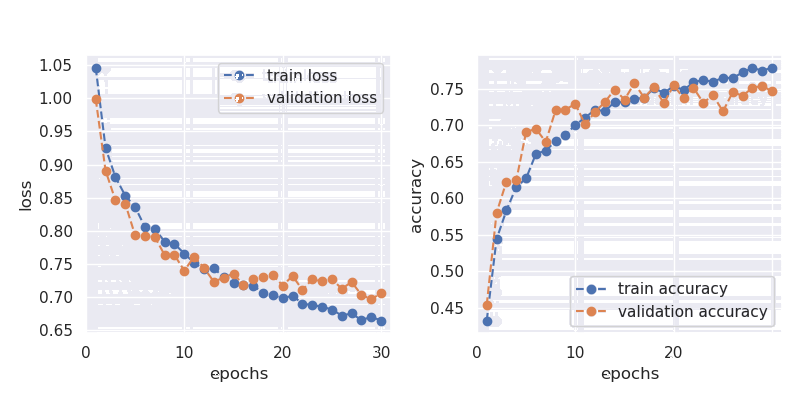

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

<IPython.core.display.Javascript object>


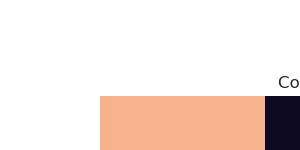

    train_loss  val_loss  train_accuracy  val_accuracy
1     1.046280  0.998875        0.432536      0.453925
2     0.925005  0.890829        0.544193      0.580205
3     0.881220  0.846195        0.583476      0.622867
4     0.853057  0.841032        0.615713      0.624573
5     0.835877  0.793352        0.627455      0.691126
6     0.805810  0.791693        0.661187      0.695392
7     0.803157  0.790902        0.665457      0.677474
8     0.783539  0.763452        0.678693      0.720990
9     0.780157  0.763451        0.687020      0.721843
10    0.765682  0.739747        0.700683      0.729522
11    0.751528  0.761044        0.710717      0.701365
12    0.742384  0.743873        0.721605      0.718430
13    0.743512  0.723178        0.719471      0.732082
14    0.729756  0.729202        0.732280      0.749147
15    0.721342  0.735482        0.731640      0.735495
16    0.718099  0.717808        0.735909      0.757679
17    0.717138  0.726710        0.738258      0.738055
18    0.70

In [18]:
model = MLP(in_features = 200 * 200, out_features = 3, hidden_layers = 1, num_hidden_units = 40, dropout = True, p = 0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)
loss_func = torch.nn.CrossEntropyLoss()
params = {"num_classes": 3}
trainer = build_training_system(model, optimizer, loss_func, tl, vl, device, **params)
_ = trainer.run(tl, max_epochs = 30)

### Aufgabe 4

In [19]:
class MyCNN(torch.nn.Module):
    def __init__(self, in_channels = 1, out_channels = 8, hidden_channels = 4, in_dim = 200*200, out_dim = 3, dropout=0.5, linear_layer_hidden_dimension = 1000):
        super().__init__()
        self.flatten = torch.nn.Flatten(start_dim=1, end_dim=-1)
        self.cnn_layers = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels, out_channels=hidden_channels, padding='same', stride=1, kernel_size=3),
            torch.nn.BatchNorm2d(hidden_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(p=dropout),
            torch.nn.MaxPool2d(kernel_size=(2,2)),
            
            torch.nn.Conv2d(in_channels=hidden_channels, out_channels=out_channels, padding='same', stride=1, kernel_size=3),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(p=dropout),
            torch.nn.MaxPool2d(kernel_size=(2,2)),
        )
        self.linear_layers = torch.nn.Sequential(
            torch.nn.Linear((out_channels*(in_dim+1)//4+1)//4,linear_layer_hidden_dimension), #torch.nn.Linear(out_channels*50*50,100)
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(in_features=linear_layer_hidden_dimension, out_features=out_dim),
            torch.nn.LogSoftmax(dim=1),
        )
        
    def forward(self, x):
        #print("1: ",x.shape)
        x = self.cnn_layers(x)
        #print("2: ",x.shape)
        x = self.flatten(x)
        #print("3: ",x.shape)
        x = self.linear_layers(x)
        #print("4: ",x.shape)
        return x

In [20]:
cnn_model = MyCNN(linear_layer_hidden_dimension = 30).to(device)
#optimizer = torch.optim.Adam(cnn_model.parameters(), lr = 0.01)
#loss_func=torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr = 0.0003)
loss_func = torch.nn.NLLLoss()
print(cnn_model)

MyCNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.5, inplace=False)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=20000, out_features=30, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=30, out_features=3, bias=True)
    (3): LogSoftmax(dim=1)
  )
)


<IPython.core.display.Javascript object>


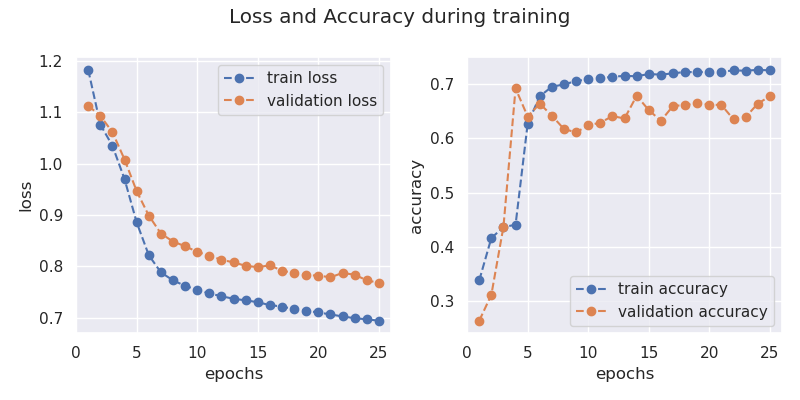

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

    train_loss  val_loss  train_accuracy  val_accuracy
1     1.182730  1.112986        0.337959      0.263652
2     1.076237  1.093220        0.416097      0.311433
3     1.034857  1.061365        0.436166      0.436860
4     0.969834  1.008140        0.440649      0.691980
5     0.885654  0.946512        0.627028      0.639932
6     0.821834  0.898937        0.677412      0.663823
7     0.788450  0.864047        0.695132      0.641638
8     0.772806  0.848435        0.699189      0.616894
9     0.762152  0.839313        0.705594      0.610922
10    0.754505  0.828395        0.708796      0.623720
11    0.747348  0.820820        0.710290      0.628840
12    0.741991  0.812985        0.713493      0.640785
13    0.736950  0.807845        0.714987      0.636519
14    0.733955  0.801216        0.714347      0.678328
15    0.730307  0.798537        0.718403      0.651877
16    0.724622  0.802165        0.717336      0.632253
17    0.721842  0.791536        0.719684      0.659556
18    0.71

State:
	iteration: 475
	epoch: 25
	epoch_length: 19
	max_epochs: 25
	output: <class 'tuple'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>
	evaluator: <class 'ignite.engine.engine.Engine'>
	data: <class 'pandas.core.frame.DataFrame'>
	index: 26
	tqdm_logger: <class 'ignite.contrib.handlers.tqdm_logger.ProgressBar'>
	start_time: 1673296407.33663
	figure: <class 'matplotlib.figure.Figure'>
	loss_axis: <class 'matplotlib.axes._subplots.AxesSubplot'>
	acc_axis: <class 'matplotlib.axes._subplots.AxesSubplot'>

In [21]:
cnn_trainer = build_training_system(model=cnn_model, optimizer=optimizer, loss_func=loss_func, train_loader=tl, val_loader=vl, device=device) 
cnn_trainer.run(tl, max_epochs = 25)

### Aufgabe 5

In [22]:
def calculate_padding(kernel_size):
    if isinstance(kernel_size, collections.abc.Sequence):
        a = (kernel_size[0]-1)//2
        b = (kernel_size[1]-1)//2
        return (a, b)
    else:
        a = (kernel_size-1)//2
        return (a, a)

def unpack_sequence(values, index):
    if isinstance(values, collections.abc.Sequence):
        if index < len(values):
            return values[index]
        return values[len(values)-1]
    return values


class ResBlock(torch.nn.Module):
    def __init__(self,
                 in_channels = 1, 
                 out_channels = 9, 
                 hidden_channels = 5, 
                 stride = 1, 
                 batchnorm = True, 
                 dropout = True, 
                 dropout_p = 0.5, 
                 kernel_size = 3):
        super().__init__()
        pad = calculate_padding(kernel_size)
        self.projection = torch.nn.Conv2d(in_channels = in_channels, out_channels=out_channels, stride=stride, kernel_size=1)
        
        self.block1 = torch.nn.Sequential ()
        self.block2 = torch.nn.Sequential ()
        self.last_layer = torch.nn.Sequential ()

        self.block1.add_module('conv1', torch.nn.Conv2d(in_channels = in_channels, out_channels = hidden_channels, padding = pad, stride = stride, kernel_size = kernel_size))
        self.block2.add_module('conv2', torch.nn.Conv2d(in_channels = hidden_channels, out_channels = out_channels, padding = pad, stride = 1, kernel_size = kernel_size))

        if batchnorm:
            self.block1.add_module('norm1', torch.nn.BatchNorm2d(hidden_channels))
            self.block2.add_module('norm2', torch.nn.BatchNorm2d(num_features=out_channels))

        self.block1.add_module('relu1', torch.nn.ReLU())
        self.last_layer.add_module('relu2', torch.nn.ReLU())

        if dropout:
            self.block1.add_module('dropout1', torch.nn.Dropout(p=dropout_p))
            self.last_layer.add_module('dropout2', torch.nn.Dropout(p=dropout_p))
            
    def forward(self,x):
        identity = x
        x = self.block1(x)
        x = self.block2(x)
        return self.last_layer(self.projection(identity) + x)
            
class ResNet(torch.nn.Module):
    def __init__(self, 
                 in_dim = 200*200,
                 out_dim = 3,
                 num_blocks=4,
                 in_channels=1,
                 hidden_channels=[16,16,32,32,64,64],
                 stride=2, 
                 batchnorm=True, 
                 dropout=True, 
                 dropout_p=0.5, 
                 kernel_size=3):
        super().__init__()
        
        # Calculate the hidden_channels based on the given input.
        if num_blocks == 1:
            hidden_channels = [unpack_sequence(hidden_channels, 0), out_channels]
        elif isinstance(hidden_channels, collections.abc.Sequence):
            hidden_channels = list(hidden_channels)
        else:
            hidded_channels = [hidden_channels] * (2 * num_blocks - 1) + [out_channels]
        
        # Calculate the convolution blocks the same for all cases.
        hl = []
        last_in = in_channels
        for i in range(len(hidden_channels) // 2):
            params = dict(
                in_channels = last_in,
                hidden_channels = unpack_sequence(hidden_channels, 2 * i),
                out_channels = unpack_sequence(hidden_channels, 2 * i + 1),
                stride = unpack_sequence(stride, i),
                dropout = unpack_sequence(dropout, i),
                batchnorm = unpack_sequence(batchnorm, i),
                dropout_p = unpack_sequence(dropout_p, i),
                kernel_size = unpack_sequence(kernel_size, i)
            )
            hl.append(ResBlock(**params))
            last_in = unpack_sequence(hidden_channels, 2 * i + 1)  

        # Add the convolution blocks into the network.
        self.res_layers = torch.nn.Sequential(
            *hl,
        )
        self.pol_layer = torch.nn.Sequential(
            torch.nn.MaxPool2d(kernel_size=(2,2)),
            torch.nn.Flatten(start_dim=1, end_dim=-1),
        )
        
        # Too lazy to calculate this with all strides.
        C = in_channels
        N = int(math.sqrt(in_dim))
        size = (1, C, N, N)
        x = torch.zeros(size)
        y = self.res_layers(x)
        y = self.pol_layer(y)
        output_size = torch.numel(y)
        
        self.linear_layer = torch.nn.Sequential(
            torch.nn.Linear(output_size, out_features=out_dim),
            torch.nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        #print("1.: ", x.shape)
        x = self.res_layers(x)
        #print("res: ",x.shape)
        x = self.pol_layer(x)
        #print("flattend: ",x.shape)
        x = self.linear_layer(x)
        return x

In [23]:
res_model = ResNet(hidden_channels=[16,16,32,32,64,64], stride = 3, kernel_size = 5, dropout_p = 0.2).to(device)
#optimizer = torch.optim.Adam(res_model.parameters(), lr = 0.01)
#loss_func=torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(res_model.parameters(), lr = 0.0003)
loss_func = torch.nn.NLLLoss()
print(res_model)

ResNet(
  (res_layers): Sequential(
    (0): ResBlock(
      (projection): Conv2d(1, 16, kernel_size=(1, 1), stride=(3, 3))
      (block1): Sequential(
        (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
        (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU()
        (dropout1): Dropout(p=0.2, inplace=False)
      )
      (block2): Sequential(
        (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (last_layer): Sequential(
        (relu2): ReLU()
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
    (1): ResBlock(
      (projection): Conv2d(16, 32, kernel_size=(1, 1), stride=(3, 3))
      (block1): Sequential(
        (conv1): Conv2d(16, 32, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
        (norm1): BatchNorm2d(32, eps=1e-05, momentu

In [24]:
res_model5 = ResNet(num_blocks=4,hidden_channels=[16,16,32,32,64,64], stride = 3, kernel_size = 5, dropout_p = 0.2).to(device)
res_model5

ResNet(
  (res_layers): Sequential(
    (0): ResBlock(
      (projection): Conv2d(1, 16, kernel_size=(1, 1), stride=(3, 3))
      (block1): Sequential(
        (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
        (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU()
        (dropout1): Dropout(p=0.2, inplace=False)
      )
      (block2): Sequential(
        (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (last_layer): Sequential(
        (relu2): ReLU()
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
    (1): ResBlock(
      (projection): Conv2d(16, 32, kernel_size=(1, 1), stride=(3, 3))
      (block1): Sequential(
        (conv1): Conv2d(16, 32, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
        (norm1): BatchNorm2d(32, eps=1e-05, momentu

<IPython.core.display.Javascript object>


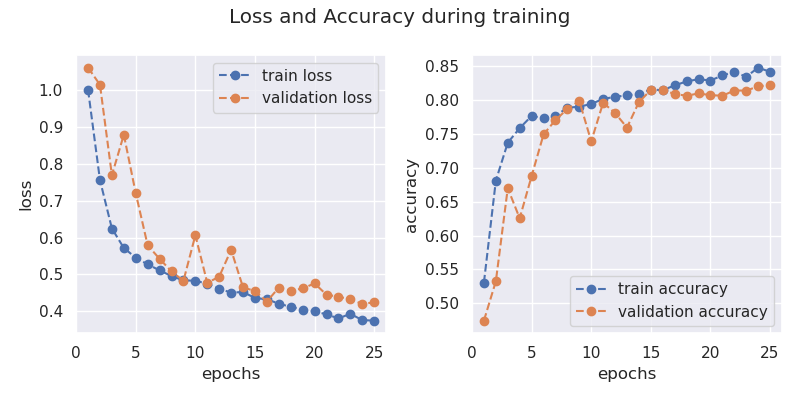

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

[1/19]   5%|5          [00:00<?]

    train_loss  val_loss  train_accuracy  val_accuracy
1     1.000866  1.060862        0.530529      0.474403
2     0.755772  1.014425        0.681042      0.532423
3     0.624496  0.768985        0.736977      0.669795
4     0.571838  0.878996        0.758540      0.625427
5     0.545245  0.720338        0.776473      0.687713
6     0.527273  0.578885        0.773057      0.749147
7     0.511002  0.542305        0.776687      0.770478
8     0.495515  0.508112        0.788642      0.786689
9     0.483967  0.482543        0.790137      0.798635
10    0.482748  0.606149        0.794193      0.738908
11    0.474679  0.477024        0.801665      0.796075
12    0.460736  0.493856        0.804654      0.780717
13    0.450865  0.566739        0.807003      0.759386
14    0.452029  0.464577        0.808924      0.796928
15    0.436305  0.455019        0.815329      0.814846
16    0.432177  0.426374        0.814688      0.814846
17    0.420925  0.464324        0.821520      0.808874
18    0.41

State:
	iteration: 475
	epoch: 25
	epoch_length: 19
	max_epochs: 25
	output: <class 'tuple'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>
	evaluator: <class 'ignite.engine.engine.Engine'>
	data: <class 'pandas.core.frame.DataFrame'>
	index: 26
	tqdm_logger: <class 'ignite.contrib.handlers.tqdm_logger.ProgressBar'>
	start_time: 1673296681.2749283
	figure: <class 'matplotlib.figure.Figure'>
	loss_axis: <class 'matplotlib.axes._subplots.AxesSubplot'>
	acc_axis: <class 'matplotlib.axes._subplots.AxesSubplot'>

In [25]:
res_trainer = build_training_system(res_model, optimizer, loss_func, tl, vl, device)
res_trainer.run(tl, max_epochs = 25)

## Aufgabe 6

In [42]:
def hyperparameter_optimization(trial, train_loader, val_loader, epochs):
    num_blocks = trial.suggest_int("num_blocks", 2, 4)
    
    hidden_channels = []
    for i in range(num_blocks):
        hidde_channel = trial.suggest_int(f"hidden_channels_{num_blocks}_{i}", 16, 128, step=16)
        hidden_channels.append(hidde_channel)
        hidden_channels.append(hidde_channel)

    stride = trial.suggest_int("stride", 1, 3, log=True)
    batchnorm = trial.suggest_categorical("batchnorm", [True, False])
    dropout = trial.suggest_categorical("dropout", [True, False])
    dropout_p = trial.suggest_float("dropout_p", 0.0, 0.7, step=0.1)
    kernel_size = trial.suggest_int("kernel_size", 1, 5, step=2)
        
    model = ResNet(num_blocks=num_blocks,
                   stride=stride, 
                   batchnorm=batchnorm, 
                   dropout=dropout, 
                   dropout_p=0.5, 
                   kernel_size=3)
    model = model.to(device)
        
    optimizer = trial.suggest_categorical("optimizer", ["Adam", "RMSprop"])
    
    if optimizer == "Adam":
        lr = trial.suggest_float("lr_adam", 1e-5, 1e-2, log=True)
        use_weight_decay = trial.suggest_categorical("use_weight_decay_adam", [True, False])
        if use_weight_decay:
            weight_decay = trial.suggest_float("weight_decay_adam", 1e-5, 1e-3, log=True)
        else:
            weight_decay = 0
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)     
    elif optimizer == "RMSprop":
        lr = trial.suggest_float("lr_rmsprop", 1e-5, 1e-2, log=True)
        centered = trial.suggest_categorical("center_rmsprop", [True, False])
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, centered=centered)    

    loss_func = trial.suggest_categorical("loss_func", ["NLLLoss", "CrossEntropyLoss"])
    if loss_func == "NLLLoss":
        loss_func = torch.nn.NLLLoss()
    elif loss_func == "CrossEntropyLoss":
        loss_func = torch.nn.CrossEntropyLoss()
        
    trainer = build_training_system(model, optimizer, loss_func, train_loader, val_loader, device=device)
    trainer.run(train_loader, max_epochs=epochs)
    return trainer.state.evaluator.state.metrics["accuracy"] # Wir optimieren auf maximale Validation-Accuracy

/home/lukas/.conda/envs/neural-network/lib/python3.10/site-packages/optuna/distributions.py:359: FutureWarning: Samplers and other components in Optuna will assume that `step` is 1. `step` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change.
  warnings.warn(


<IPython.core.display.Javascript object>


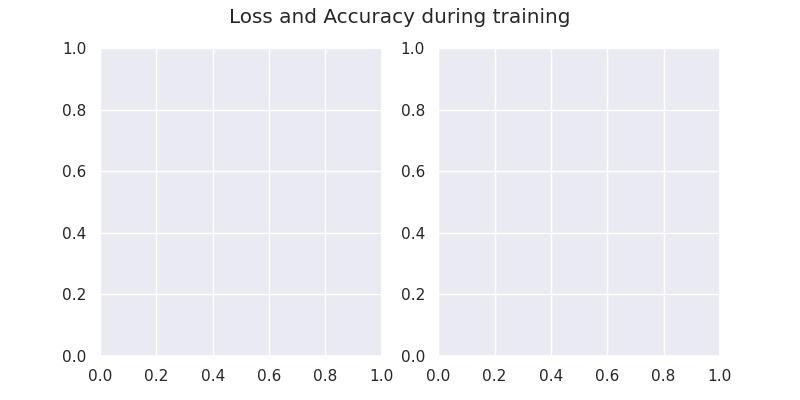

Current run is terminating due to exception: CUDA out of memory. Tried to allocate 40.00 MiB (GPU 0; 1.96 GiB total capacity; 1.34 GiB already allocated; 6.31 MiB free; 1.35 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Engine run is terminating due to exception: CUDA out of memory. Tried to allocate 40.00 MiB (GPU 0; 1.96 GiB total capacity; 1.34 GiB already allocated; 6.31 MiB free; 1.35 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


OutOfMemoryError: CUDA out of memory. Tried to allocate 40.00 MiB (GPU 0; 1.96 GiB total capacity; 1.34 GiB already allocated; 6.31 MiB free; 1.35 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [49]:
if False:
    hyperparameter_optimization(optuna.trial.FixedTrial({
        "num_blocks": 3,
        "hidden_channels_3_0": 16,
        "hidden_channels_3_1": 32,
        "hidden_channels_3_2": 64,
        "stride": 3,
        "batchnorm": True,
        "dropout": True,
        "dropout_p": 0.2,
        "kernel_size": 5,
        "optimizer": "Adam",
        "lr_adam": 0.003,
        "use_weight_decay_adam": True,
        "weight_decay_adam": 0.0001,
        "loss_func": "NLLLoss"
    }), epochs=10, train_loader=tl, val_loader=vl)

In [43]:
objective = functools.partial(hyperparameter_optimization, epochs=10, train_loader=tl, val_loader=vl)
sampler = optuna.samplers.TPESampler(multivariate=True, group=True)
study = optuna.create_study(study_name="MResNetStudy", direction="maximize")
study.optimize(objective, n_trials=30)

/home/lukas/.conda/envs/neural-network/lib/python3.10/site-packages/optuna/samplers/_tpe/sampler.py:263: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/lukas/.conda/envs/neural-network/lib/python3.10/site-packages/optuna/samplers/_tpe/sampler.py:274: ExperimentalWarning: ``group`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2023-01-09 22:26:52,952] A new study created in memory with name: MResNetStudy
[W 2023-01-09 22:26:53,115] Trial 0 failed because of the following error: OutOfMemoryError('CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 1.96 GiB total capacity; 1.34 GiB already allocated; 6.31 MiB free; 1.35 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
Traceback (most recent call last

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 1.96 GiB total capacity; 1.34 GiB already allocated; 6.31 MiB free; 1.35 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
print(stud.best_params)

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_edf(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_slice(study)

# Aufgabe 5 (alternativ)

In [ ]:
import torch.nn as nn

class ResidualBlock(nn.Module):

  def __init__(self, input_channels, out_channels, intermediate_channels = 0, downsample=False):

    super().__init__()

    self.input_channels = input_channels
    self.output_channels = out_channels
    self.downsample = downsample
    self.stride = 1
    self.intermediate_channels = self.input_channels
    self.relu = nn.ReLU()

    if self.downsample:
      self.stride = 2
      self.intermediate_channels = intermediate_channels

    self.c1 = nn.Conv2d(in_channels = self.input_channels, out_channels=self.intermediate_channels, stride=self.stride, kernel_size=3, padding=1)
    self.norm1 = nn.BatchNorm2d(num_features=self.output_channels)

    self.c2 = nn.Conv2d(in_channels = self.intermediate_channels, out_channels=self.output_channels, stride=1, kernel_size=3, padding=1)
    self.norm2 = nn.BatchNorm2d(num_features=self.output_channels)
    
    self.lin_projection = nn.Conv2d(in_channels = self.input_channels, out_channels=self.output_channels, stride=self.stride, kernel_size=1)


  def forward(self, x):
    identity = x

    if self.downsample:
      identity = self.lin_projection(identity)

    # Block 1
    x = self.c1(x)
    x = self.norm1(x)
    x = self.relu(x)

    # Block 2

    x = self.c2(x)
    x = self.norm2(x)
    x = self.relu(x)

    x = x + identity
    x = self.relu(x)
    return x


In [ ]:
# TODO write a class ResNet(nn.Module) where you define the model

class ResNet(nn.Module):

  def __init__(self, verbose=False):

    super().__init__()
    self.relu = nn.ReLU()
    self.verbose = verbose

    ##### Conv1
    self.c1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size = 3, stride=2, padding=1)
    self.norm1 = nn.BatchNorm2d(num_features = 32)

    ##### Conv1_x
    self.rb11 = ResidualBlock(32, 32, False)
    self.rb12 = ResidualBlock(32, 32, False)

    ##### Conv2_x
    self.rb21 = ResidualBlock(32, 64, intermediate_channels = 64, downsample = True)
    self.rb22 = ResidualBlock(64, 64, False)

    ##### Conv3_x
    self.rb31 = ResidualBlock(64, 128, intermediate_channels = 128, downsample = True)
    self.rb32 = ResidualBlock(128, 128, False)

    ##### Conv4_x
    self.rb41 = ResidualBlock(128, 256, intermediate_channels = 256, downsample = True)
    self.rb42 = ResidualBlock(256, 256, False)

    ##### Last Layer
    self.avgPool = nn.AvgPool2d(kernel_size = 7)
    self.fc1 = nn.Linear(256, 10)

  def forward(self, x):
    
    ##### Conv1
    if self.verbose:
      print("x shape: ", x.shape)
      print("-----Conv1-----")
    x = self.relu(self.norm1(self.c1(x)))

    ##### Conv1_x
    if self.verbose:
      print("x shape: ", x.shape)
      print("-----Conv1_x-----")
    x = self.rb11(x)
    x = self.rb12(x)

    ##### Conv2_x
    if self.verbose:
      print("x shape: ", x.shape)
      print("-----Conv2_x-----")
    x = self.rb21(x)
    x = self.rb22(x)

    ##### Conv3_x
    if self.verbose:
      print("x shape: ", x.shape)
      print("-----Conv3_x-----")
    x = self.rb31(x)
    x = self.rb32(x)

    ##### Conv4_x
    if self.verbose:
      print("x shape: ", x.shape)
      print("-----Conv4_x-----")
    x = self.rb41(x)
    x = self.rb42(x)



    ##### 2nd Red Layer
    if self.verbose: print("-----last layer-----")
    x = self.avgPool(x)

    if self.verbose: print("x shape after avgpool: ", x.shape)
    x = torch.flatten(x,1)
    
    if self.verbose: print("x shape after flatten: ", x.shape)
    x = self.fc1(x)

    return x
    






In [ ]:
resnet2 = ResNet().to(device)

In [ ]:
# TODO train ResNet, using the architecture laid out in the comments and figures above


Epochs = 10
lr = 0.01

optimizer_resnet = torch.optim.Adam(resnet2.parameters(), lr = lr)
loss_function = nn.CrossEntropyLoss()


# train_losses_resnet, val_losses_resnet, train_accs_resnet, val_accs_resnet, confusion_matrix_resnet = utils.run_training(resnet2, optimizer_resnet, loss_function, device, Epochs, trainloader, valloader, early_stopper=None, verbose=True)

res_trainer = build_training_system(resnet2, optimizer_resnet, loss_function, tl, vl, device)
res_trainer.run(tl, max_epochs = 25)

# Aufgabe 6

In [ ]:
def hyperparameter_optimization(trial, train_loader, val_loader, epochs):    
        
  model = ResNet()
  if use_cuda:
      model = model.cuda()
      
  optimizer = trial.suggest_categorical("optimizer", ["Adam", "RMSprop"]) # Auch kategorische Variablen sind möglich

  if optimizer == "Adam":
      lr = trial.suggest_float("lr_adam", 1e-5, 1e-2, log=True)
      use_weight_decay = trial.suggest_categorical("use_weight_decay_adam", [True, False])
      if use_weight_decay:
          weight_decay = trial.suggest_float("weight_decay_adam", 1e-5, 1e-3, log=True)
      else:
          weight_decay = 0
      optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)     
  elif optimizer == "RMSprop":
      lr = trial.suggest_float("lr_rmsprop", 1e-5, 1e-2, log=True)
      centered = trial.suggest_categorical("center_rmsprop", [True, False])
      optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, centered=centered)    

  loss_func = trial.suggest_categorical("loss_func", (["NLL_Loss", "Cross_Entropy_Loss"])

  if loss_func == "NLL_Loss":    
    loss_func = torch.nn.NLLLoss()
  else:
    loss_func = nn.CrossEntropyLoss()



  trainer = build_training_system(model, optimizer, loss_func, train_loader, val_loader)

  trainer.run(train_loader, max_epochs=epochs)
  return trainer.state.evaluator.state.metrics["accuracy"] # Wir optimieren auf maximale Validation-Accuracy